In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


- No missing values

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

- Transform the 'date' attribute to datetime data type

In [5]:
{column: len(df[column].unique()) for column in df.columns}

{'date': 1826, 'store': 10, 'item': 50, 'sales': 213}

- Unique values in individual column

In [6]:
print('- Data collection from', df['date'].min(), 'to', df['date'].max())
print('- Dataset includes 50 items from 10 stores')

- Data collection from 2013-01-01 00:00:00 to 2017-12-31 00:00:00
- Dataset includes 50 items from 10 stores


In [7]:
df_train = df[df['store']==1]
df_train = df_train[df_train['item']==1]

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.dayofyear
df_train['weekday'] = df_train['date'].dt.weekday

df_train

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,361,2
1822,2017-12-28,1,1,19,2017,12,362,3
1823,2017-12-29,1,1,15,2017,12,363,4
1824,2017-12-30,1,1,27,2017,12,364,5


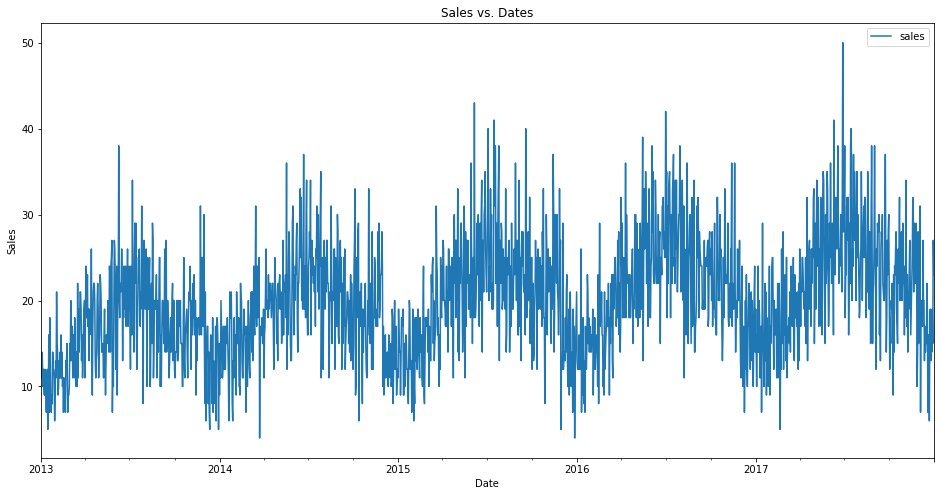

In [8]:
df_train.plot('date', 'sales', figsize=(16, 8))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales vs. Dates')
plt.show();

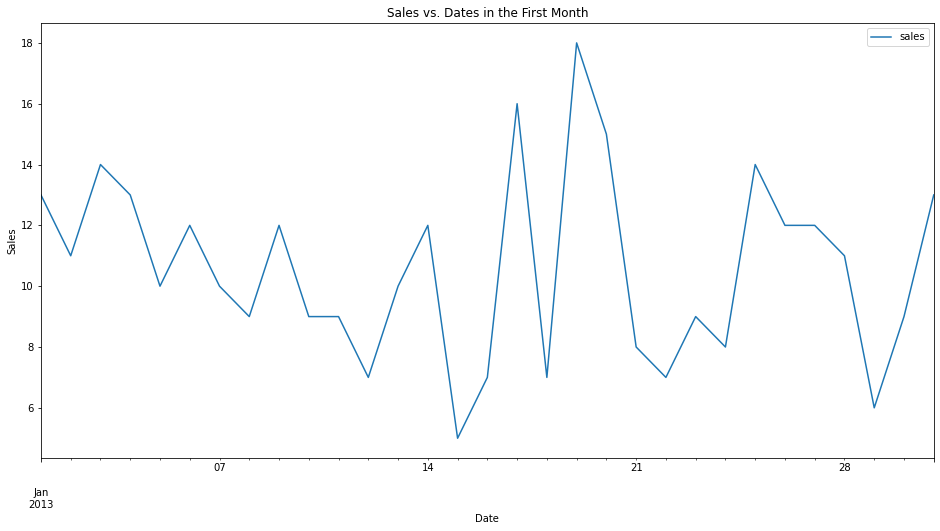

In [9]:
df_train[:31].plot('date', 'sales', figsize=(16, 8))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales vs. Dates in the First Month')
plt.show();

- Upward trend in sales over the years
- Seasonal pattern identified, with mid-year as sales peak

In [10]:
day_0 = df_train[df_train['weekday']==0]['sales']
day_1 = df_train[df_train['weekday']==1]['sales']
day_2 = df_train[df_train['weekday']==2]['sales']
day_3 = df_train[df_train['weekday']==3]['sales']
day_4 = df_train[df_train['weekday']==4]['sales']
day_5 = df_train[df_train['weekday']==5]['sales']
day_6 = df_train[df_train['weekday']==6]['sales']

data = [day_0, day_1, day_2, day_3, day_4, day_5, day_6]
label = ['day 0', 'day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6']

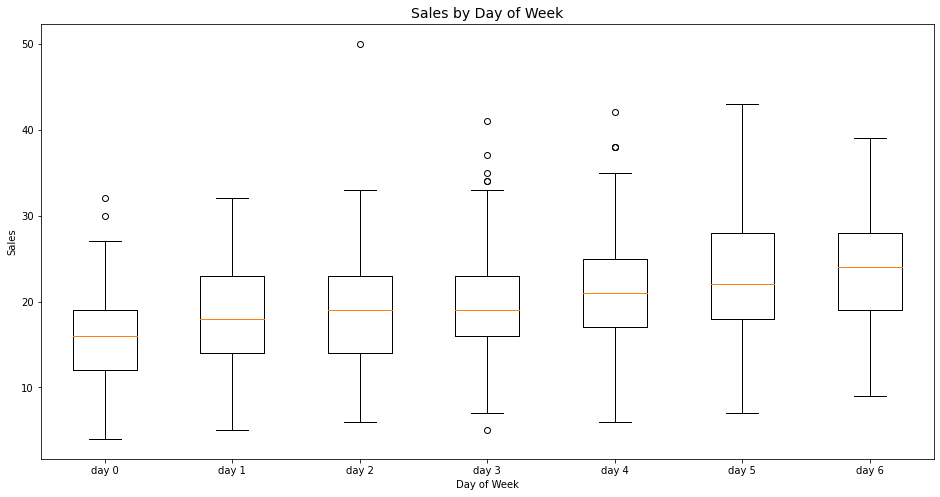

In [11]:
plt.figure(figsize=(16,8))
plt.boxplot(data, labels=label)
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.title('Sales by Day of Week', fontsize=14)
plt.show();

- Higher sales on Friday and Saturday (day 5 and day 6), Sunday with lowest sales
- Outliers on Tuesday, Wednesday and Thursday

In [12]:
df_train = df_train.set_index('date')
df_train['sales'] = df_train['sales'].astype(float)

df_train.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 432x288 with 0 Axes>

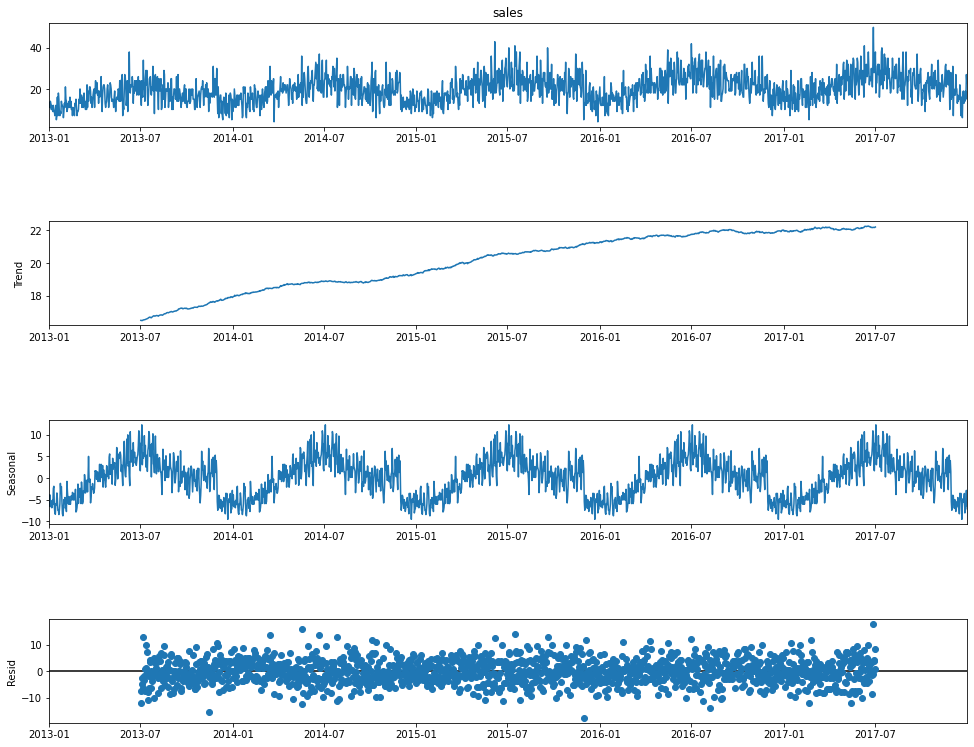

In [20]:
seasonal = seasonal_decompose(df_train['sales'], model='additive', freq=365)

fig = plt.figure()
fig = seasonal.plot()
fig.set_size_inches(15, 12)
plt.show();

- As there is a upward trend, the data is not considered stationary

_"When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable."_

In [30]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 8))
    orig = plt.plot(timeseries, color='tab:blue',label='Original')
    mean = plt.plot(rolmean, color='tab:orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='tab:green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

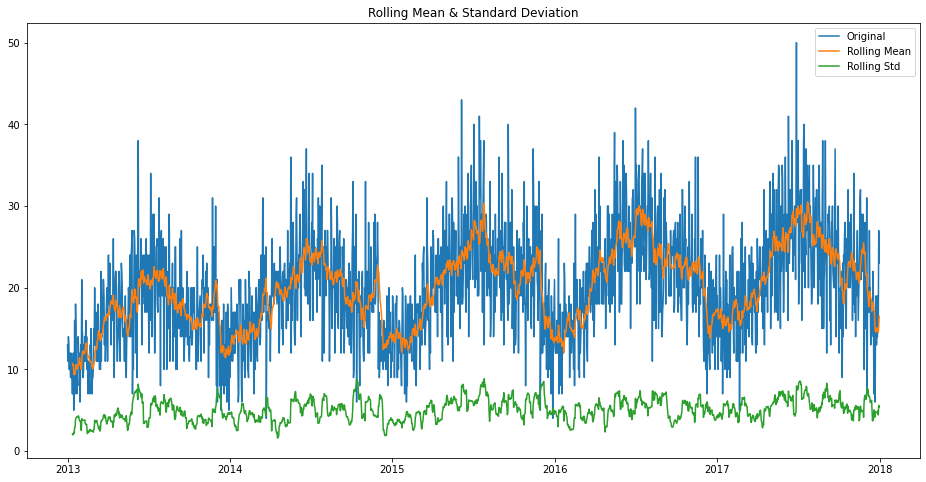

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [31]:
test_stationarity(df_train['sales'])

- Dickey-Fuller Test for dataset stationarity
- Test Statistic is not larger than Critical Value (1%), p-value = 0.0361,  therefore the data is not stationary

In [37]:
df_train['sales_shift'] = df_train.sales.shift(1)
df_train['first_diff'] = df_train.sales - df_train.sales_shift
df_first_diff = df_train['first_diff']
df_first_diff = df_first_diff.dropna()

In [41]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

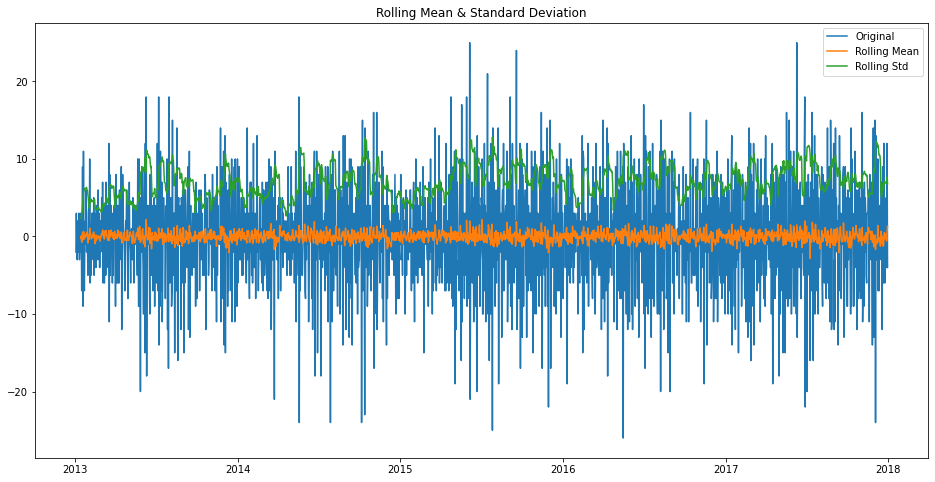

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -15.208
p-value                          0.000
#Lags Used                      20.000
Number of Observations Used   1804.000
Critical Value (1%)             -3.434
Critical Value (5%)             -2.863
Critical Value (10%)            -2.568
dtype: float64


In [42]:
test_stationarity(df_first_diff)

- Test Statistic (-15.208) is larger than critical value (-3.434)
- df_first_diff is likely to be staionary now

Text(0.5, 1.0, 'Partial Autocorrelation Function (PAFC)')

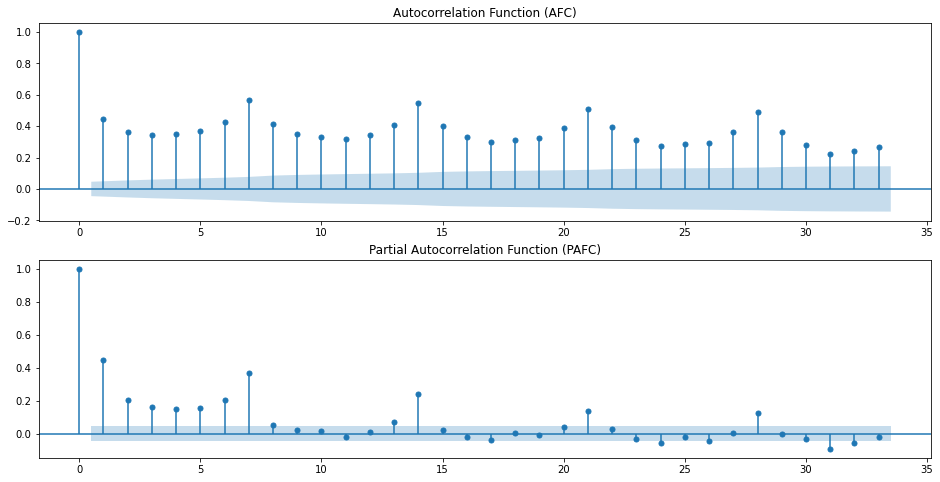

In [46]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train.sales, ax=ax1)
plt.title('Autocorrelation Function (AFC)')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train.sales, ax=ax2)
plt.title('Partial Autocorrelation Function (PAFC)')

- ACF and PACF plot for origina data

Text(0.5, 1.0, 'Partial Autocorrelation Function (PAFC)')

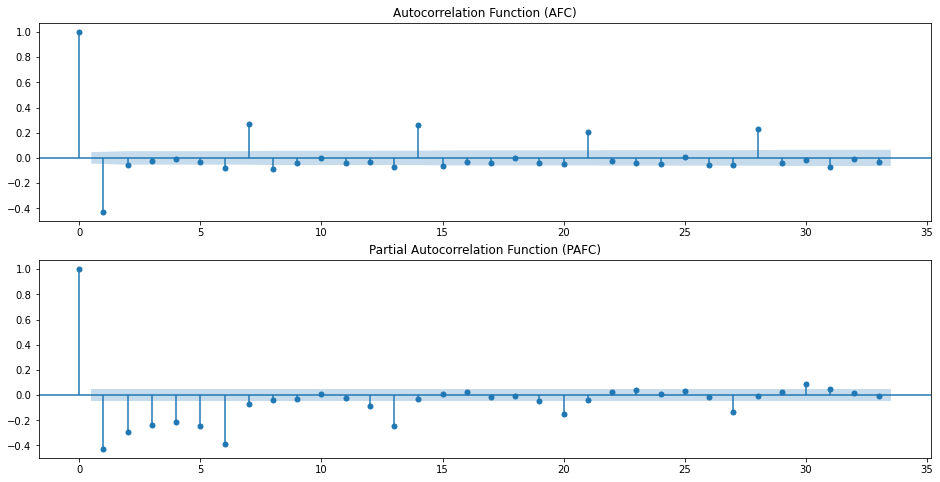

In [47]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_first_diff, ax=ax1)
plt.title('Autocorrelation Function (AFC)')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_first_diff, ax=ax2)
plt.title('Partial Autocorrelation Function (PAFC)')

- ACF and PACF plot for data with 1 differencing
- Here we can see the ACF and PACF both has a recurring pattern every 7 periods, indicating the existance of a weekly pattern. 
- SARIMA would be considered as there is a significant seasonal pattern